In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

# Display the version
print(tf.__version__)

# import and mount Drive
import os
from google.colab import drive
drive.mount('/content/gdrive')

2.13.0
Mounted at /content/gdrive


In [2]:
# get path to folder file is in
!pip install kora
from kora.drive import get_path
file_path = get_path('17rNCLBHSPszyoaacFSpsFGD5nlP1OBF7')
file_path = '/content/gdrive/' + str(file_path) + '/Fashion-MNIST'
print(file_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.8 MB/s eta 0:00:00
/content/gdrive/My Drive/Personal Projects/Pioneer Academics Research/code/Fashion-MNIST


In [3]:
# Download the data from tf, unless it's already here.
if not os.path.exists(file_path+'/data/clean'):
  os.mkdir(file_path+'/data/clean')
  (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  np.save(file_path+'/data/clean/X_train.npy',X_train)
  np.save(file_path+'/data/clean/y_train.npy',y_train)
  np.save(file_path+'/data/clean/X_test.npy',X_test)
  np.save(file_path+'/data/clean/y_test.npy',y_test)
else:
  X_train = np.load(file_path+'/data/clean/X_train.npy')
  y_train = np.load(file_path+'/data/clean/y_train.npy')
  X_test = np.load(file_path+'/data/clean/X_test.npy')
  y_test = np.load(file_path+'/data/clean/y_test.npy')

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


In [4]:
# Convert to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# reshape dataset to have a single channel
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Decrease pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
# Load in Clean Model
model = tf.keras.models.load_model(file_path+'/models/clean.keras')

In [6]:
# Create FGSM Perturbed Data
def create_fgsm_perturbations(data_inputs, data_labels, epsilon = 0.1):
  input_tensor = tf.convert_to_tensor(data_inputs)
  label_tensor = tf.convert_to_tensor(data_labels)
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    output_tensor = model(input_tensor)
    loss = loss_fn(label_tensor, output_tensor)

  gradient = tape.gradient(loss, input_tensor)
  perturbed_input_tensor = input_tensor + epsilon * tf.sign(gradient)
  return tf.cast(perturbed_input_tensor, dtype=input_tensor.dtype)

# Create FGSM perturbations if nonexisting, else load them
if not os.path.exists(file_path+'/data/FGSM_perturbed'):
  os.mkdir(file_path+'/data/FGSM_perturbed')

  perturbed_data = [None for _ in range(6)]
  for i in range(6):
    perturbed_data[i] = create_fgsm_perturbations(X_train[i * 10000:(i+1) * 10000], y_train[i * 10000:(i+1) * 10000])

  X_FGSM_train = np.concatenate(perturbed_data, axis=0)
  X_FGSM_test = create_fgsm_perturbations(X_test, y_test)

  np.save(file_path+'/data/FGSM_perturbed/X_FGSM_train.npy',X_FGSM_train)
  np.save(file_path+'/data/FGSM_perturbed/X_FGSM_test.npy',X_FGSM_test)
else:
  X_FGSM_train = np.load(file_path+'/data/FGSM_perturbed/X_FGSM_train.npy')
  X_FGSM_test = np.load(file_path+'/data/FGSM_perturbed/X_FGSM_test.npy')

print("X_FGSM_train shape", X_FGSM_train.shape)
print("y_train shape", y_train.shape)
print("X_FGSM_test shape", X_FGSM_test.shape)
print("y_test shape", y_test.shape)

X_FGSM_train shape (60000, 28, 28, 1)
y_train shape (60000,)
X_FGSM_test shape (10000, 28, 28, 1)
y_test shape (10000,)


In [7]:
# Clip perturbed training and test data to viable values
X_FGSM_train = np.clip(X_FGSM_train, a_min = 0.0, a_max = 1.0)
X_FGSM_test = np.clip(X_FGSM_test, a_min = 0.0, a_max = 1.0)

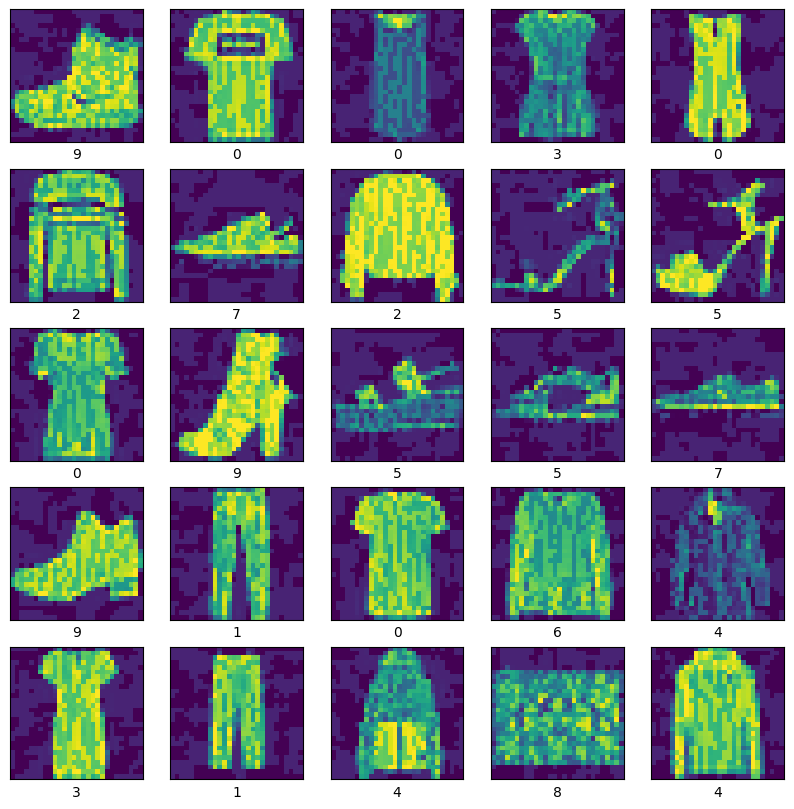

In [8]:
# Display training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_FGSM_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(y_train[i])
plt.show()

In [9]:
model.evaluate(X_FGSM_train, y_train)
model.evaluate(X_FGSM_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 3.2335 - accuracy: 0.2201


[3.2334721088409424, 0.22010000050067902]

In [10]:
# Create PGD Perturbed Data
def create_pgd_perturbations(data_inputs, data_labels, epsilon = 0.01, n_iter = 10):
  input_tensor = tf.convert_to_tensor(data_inputs)
  label_tensor = tf.convert_to_tensor(data_labels)
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

  perturbed_tensor = input_tensor
  for i in range(n_iter):
      with tf.GradientTape() as tape:
          tape.watch(perturbed_tensor)
          output_tensor = model(perturbed_tensor)
          loss = loss_fn(label_tensor, output_tensor)

      gradient = tape.gradient(loss, perturbed_tensor)

      perturbed_tensor = perturbed_tensor + gradient
      # Project perturbed_tensor onto the L-infinity ball around input_tensor
      perturbed_tensor = epsilon * tf.sign(
          perturbed_tensor - input_tensor) + input_tensor

  perturbed_tensor = tf.cast(perturbed_tensor, dtype=input_tensor.dtype)
  return perturbed_tensor

# Create PGD perturbations if nonexisting, else load them
if not os.path.exists(file_path+'/data/PGD_perturbed'):
  os.mkdir(file_path+'/data/PGD_perturbed')

  perturbed_data = [None for _ in range(6)]
  for i in range(6):
    perturbed_data[i] = create_fgsm_perturbations(X_train[i * 10000:(i+1) * 10000], y_train[i * 10000:(i+1) * 10000])

  X_PGD_train = np.concatenate(perturbed_data, axis=0)
  X_PGD_test = create_pgd_perturbations(X_test, y_test)

  np.save(file_path+'/data/PGD_perturbed/X_PGD_train.npy',X_PGD_train)
  np.save(file_path+'/data/PGD_perturbed/X_PGD_test.npy',X_PGD_test)
else:
  X_PGD_train = np.load(file_path+'/data/PGD_perturbed/X_PGD_train.npy')
  X_PGD_test = np.load(file_path+'/data/PGD_perturbed/X_PGD_test.npy')

print("X_PGD_train shape", X_PGD_train.shape)
print("y_train shape", y_train.shape)
print("X_PGD_test shape", X_PGD_test.shape)
print("y_test shape", y_test.shape)

X_PGD_train shape (60000, 28, 28, 1)
y_train shape (60000,)
X_PGD_test shape (10000, 28, 28, 1)
y_test shape (10000,)


In [11]:
# Clip perturbed training and test data to viable values
X_PGD_train = np.clip(X_PGD_train, a_min = 0.0, a_max = 1.0)
X_PGD_test = np.clip(X_PGD_test, a_min = 0.0, a_max = 1.0)

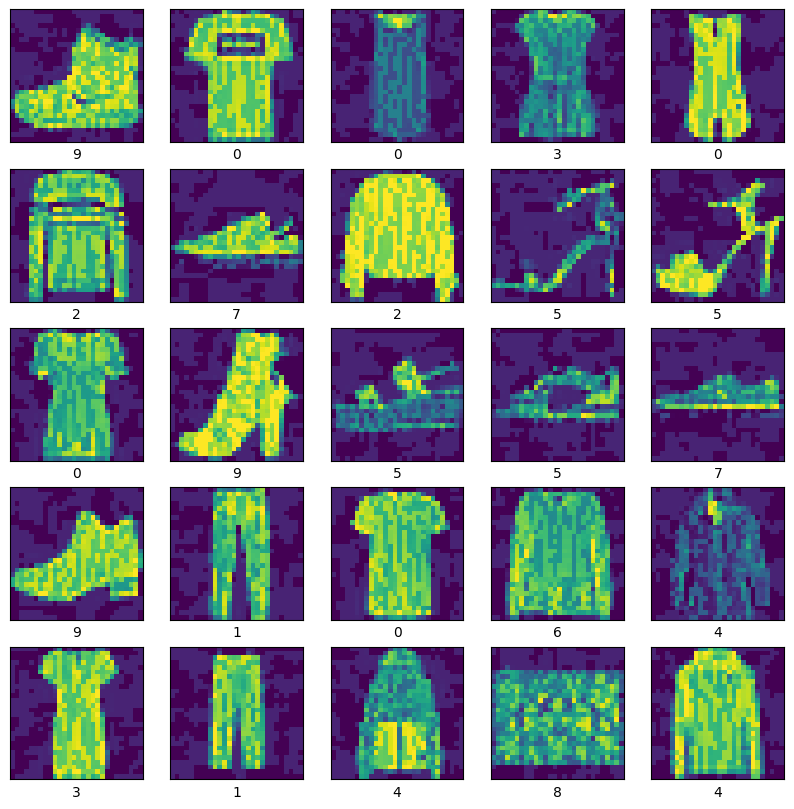

In [12]:
# Display training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_PGD_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(y_train[i])
plt.show()

In [13]:
model.evaluate(X_PGD_train, y_train)
model.evaluate(X_PGD_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.5759 - accuracy: 0.8338


[0.575874388217926, 0.8338000178337097]

In [14]:
print(X_train.shape[1:])

(28, 28, 1)


In [15]:
# Implement the chosen values in a final model, from https://github.com/rajeevsahay/ae-defenses/blob/master/Semi-white_Box_Attack_(FGSM)/pp_auto_encoder_fgsm.py
def train_autoencoder(data_total_train, data_total_test, labels_total_train = np.concatenate([X_train, X_train], axis=0), labels_total_test = np.concatenate([X_test, X_test], axis=0), file_name=(file_path + '/models/denoising_autoencoder.keras'), num_epochs = 25, batch_size=256, lr=0.0003):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=data_total_train.shape[1:]))
    model.add(tf.keras.layers.Dense(256, activation=None, use_bias=True, kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(128, activation=None, kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(64, activation=None, kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(128, activation=None, kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(256, activation=None, kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(784, activation="sigmoid", kernel_initializer="uniform"))
    model.add(tf.keras.layers.Reshape(data_total_train.shape[1:]))

    #Compile model using mean squared error as loss and adam as optimizer
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

    #Train model using input of clean and corrupted data and fit to clean reconstructions only
    model.fit(data_total_train, labels_total_train, validation_data=(data_total_test, labels_total_test), epochs=num_epochs, batch_size=batch_size, shuffle=True, verbose=1)

    model.summary()

    if file_name != None:
        model.save(file_name)

    return model

In [16]:
# Run model on FGSM and clean data
FGSM_denoising_autoencoder = train_autoencoder(np.concatenate([X_train, X_FGSM_train], axis=0), np.concatenate([X_test, X_FGSM_test], axis=0), file_name=(file_path + '/models/FGSM_denoising_autoencoder.keras'))

Epoch 1/25
469/469 [==============================] - 5s 5ms/step - loss: 0.0636 - accuracy: 0.4829 - val_loss: 0.0411 - val_accuracy: 0.4948
Epoch 2/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0406 - accuracy: 0.4962 - val_loss: 0.0387 - val_accuracy: 0.4942
Epoch 3/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0362 - accuracy: 0.4987 - val_loss: 0.0333 - val_accuracy: 0.4973
Epoch 4/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0291 - accuracy: 0.5022 - val_loss: 0.0266 - val_accuracy: 0.5014
Epoch 5/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0262 - accuracy: 0.5035 - val_loss: 0.0259 - val_accuracy: 0.5016
Epoch 6/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0258 - accuracy: 0.5036 - val_loss: 0.0253 - val_accuracy: 0.5018
Epoch 7/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0244 - accuracy: 0.5043 - val_loss: 0.0232 - val_accuracy: 0.5031
Epoch 

In [17]:
# Evaluate original model on a set the model has never seen
model.evaluate(X_FGSM_test, y_test)

# Evaluate it on a set the model has never seen
model.evaluate(FGSM_denoising_autoencoder.predict(X_FGSM_test), y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4060 - accuracy: 0.5903


[1.4059736728668213, 0.5903000235557556]

In [18]:
# Run model on PGD and clean data
PGD_denoising_autoencoder = train_autoencoder(np.concatenate([X_train, X_PGD_train], axis=0), np.concatenate([X_test, X_PGD_test], axis=0), file_name=(file_path + '/models/PGD_denoising_autoencoder.keras'))

Epoch 1/25
469/469 [==============================] - 4s 5ms/step - loss: 0.0643 - accuracy: 0.4824 - val_loss: 0.0410 - val_accuracy: 0.4931
Epoch 2/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0402 - accuracy: 0.4963 - val_loss: 0.0376 - val_accuracy: 0.4956
Epoch 3/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0333 - accuracy: 0.4998 - val_loss: 0.0304 - val_accuracy: 0.4994
Epoch 4/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0292 - accuracy: 0.5022 - val_loss: 0.0272 - val_accuracy: 0.5017
Epoch 5/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0265 - accuracy: 0.5034 - val_loss: 0.0259 - val_accuracy: 0.5010
Epoch 6/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0259 - accuracy: 0.5036 - val_loss: 0.0254 - val_accuracy: 0.5015
Epoch 7/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0244 - accuracy: 0.5043 - val_loss: 0.0232 - val_accuracy: 0.5028
Epoch 

In [19]:
# Evaluate it on a set the model has never seen
model.evaluate(PGD_denoising_autoencoder.predict(X_PGD_test))

313/313 [==============================] - 1s 1ms/step - loss: 0.0884 - accuracy: 0.0000e+00


[0.0884069949388504, 0.0]